# Thống kê Bayes sử dụng Probflow

# Bài 5: So sánh 2 phân bố Gamma

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

Chào các bạn, đây là bài thứ 5 trong loạt bài giới thiệu về probflow, một giao thức dựa trên tensorflow hoặc pytorch, giúp người dùng phổ thông thực hành thống kê Bayes dễ dàng hơn.

Lần trước, chúng ta đã từng giải quyết bài toán so sánh trung bình giữa 2 hay nhiều phân nhóm bằng mô hình probflow, các mô hình này dựa trên họ phân phối Gaussian hoặc Student t. Tuy nhiên, trong thực tế hầu hết những đại lượng sinh học thường có phân phối lệch dương chứ không đối xứng; do đó một mô hình tuyến tính sử dụng phân phối Gamma có thể sẽ phù hợp và linh hoạt hơn.

Trong bài này chúng ta sẽ thực hiện một suy diễn thống kê bằng mô hình hồi quy Gamma. Mục tiêu của bài toán là so sánh nồng độ bilirubin giữa 2 nhóm bệnh nhân mắc bệnh Viêm gan : nhóm thứ nhất bệnh nhẹ hơn và sống sót, nhóm thứ hai nặng hơn và đã tử vong; dựa theo bộ dữ liệu “hepatitis”. Nhi tải dữ liệu từ database openml.org, sau khi loại bỏ missing values,giản lược chúng ta có 149 cases, gồm 119 trường hợp sống sót và 30 trường hợp tử vong. Biến kết quả là BILIRUBIN, phân nhóm là Class.

# Thăm dò dữ liệu

In [316]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [137]:
df = pd.read_csv("https://www.openml.org/data/get_csv/55/dataset_55_hepatitis.csv",
                 na_values = '?')[['BILIRUBIN','Class']].dropna(how = 'any', axis = 0)

df.Class = df.Class.map({'LIVE': 'G1_Survived',
                         'DIE': 'G2_Dead'
                        })

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BILIRUBIN  149 non-null    float64
 1   Class      149 non-null    object 
dtypes: float64(1), object(1)
memory usage: 3.5+ KB


In [443]:
df.groupby('Class').describe(percentiles = [0.05,0.5,0.95])

BILIRUBIN                                                 
                count      mean       std  min     5%   50%   95%  max
Class                                                                 
G1_Survived     119.0  1.146218  0.722143  0.3  0.600  1.00  2.46  4.6
G2_Dead          30.0  2.543333  1.940082  0.4  0.545  1.95  6.34  8.0

Thống kê mô tả cho thấy giá trị trung bình bilirubin cao hơn ở nhóm 2 (Dead) so với nhóm 1 (Survived).
Hình ảnh phân bố ở mỗi phân nhóm có thể được khảo sát trực quan bằng KDE plot như sau:

Text(0.5, 0, 'Bilirubin')

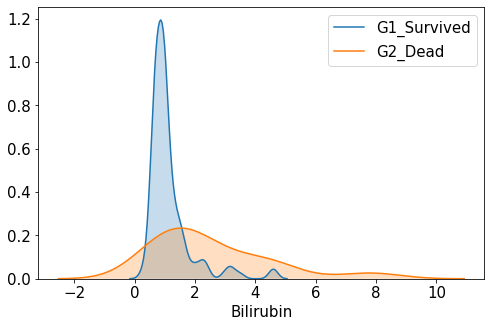

In [448]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 15})

for v in df.Class.unique():
    sns.kdeplot(df[df.Class == v]['BILIRUBIN'], label = v, shade = True)
plt.xlabel('Bilirubin')

Như ta thấy, bilirubin là 1 biến liên tục, không âm và có phân bố bất đối xứng, thậm chí hình dạng phân phối cũng không đồng nhất giữa 2 phân nhóm G1 và G2. Hồi quy Gamma là một giải pháp tốt cho trường hợp này.

# Hồi quy Gamma dùng statsmodels

Trong ngôn ngữ Python, ta có thể làm hồi quy Gamma bằng packages statsmodels như sau:

In [312]:
mod1 = smf.glm(formula='BILIRUBIN ~ Class', 
               data=df, 
               family=sm.families.Gamma(sm.families.links.identity())).fit()

mod1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:274: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn(("The %s link function does not respect the domain "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              BILIRUBIN   No. Observations:                  149
Model:                            GLM   Df Residuals:                      147
Model Family:                   Gamma   Df Model:                            1
Link Function:               identity   Scale:                         0.43341
Method:                          IRLS   Log-Likelihood:                -154.39
Date:                Sun, 16 Aug 2020   Deviance:                       46.137
Time:                        17:07:26   Pearson chi2:                     63.7
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1462      0.069     16.570      0.000       1.011       1.282
Class[T.G2_Dead]     1.3971      0.313      4.458      0.000       0.783       2.011
====================================================================================
"""

Lưu ý, mô hình này dùng link function (hàm liên kết) là identidy, do đó nội dung sẽ được diễn giải như sau:
    
Intercept = 1.1462 chính là trung bình Bilirubin của phân nhóm G1 (Survival),

Hệ số hồi quy b cho Class[T.G2_Dead] = 1.3971 chính là giá trị tăng trung bình của bilirubin của phân nhóm G2, so với G1. Từ đây ta có thể tính trung bình của phân nhóm G2 = Intercept + b = 1.3971 + 1.1462 = 2.5433

Một mô hình khác sử dụng hàm liên kết logarit:

In [313]:
mod2 = smf.glm(formula='BILIRUBIN ~ Class', 
               data=df, 
               family=sm.families.Gamma(sm.families.links.log())).fit()

mod2.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              BILIRUBIN   No. Observations:                  149
Model:                            GLM   Df Residuals:                      147
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.43341
Method:                          IRLS   Log-Likelihood:                -154.39
Date:                Sun, 16 Aug 2020   Deviance:                       46.137
Time:                        17:07:28   Pearson chi2:                     63.7
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1365      0.060      2.261      0.024       0.018       0.255
Class[T.G2_Dead]     0.7970      0.134      5.926      0.000       0.533       1.061
====================================================================================
"""

Đối với mô hình dùng hàm liên kết logarit, nếu ta chuyền đổi Intercept bằng hàm exponential, sẽ có trung bình của nhóm G1:
exp(0.1365) = 1.146

Nếu ta tính exp(b + Intercept) sẽ có giá trị trung bình của nhóm G2 = 2.543,

In [449]:
np.exp(0.1365)

1.1462548777757673

In [142]:
np.exp(0.7970 + 0.1365)

2.5433955017352687

Ta cũng có thể kết hợp statsmodels và một kỹ thuật tái chọn mẫu bootstrap để ước tính khoảng tin cậy của hệ số hồi quy b cho phân nhóm 2:

In [455]:
out_df = pd.DataFrame(columns=['Intercept','Group_2','Iter'])

for i in range(1000):
    temp_df = df.sample(df.shape[0], replace=True)
    
    mod = smf.glm(formula='BILIRUBIN ~ Class', 
               data=temp_df, 
               family=sm.families.Gamma(sm.families.links.identity())).fit()
    
    temp_df = pd.DataFrame({'Intercept': mod.params[0],
                            'Group_2': mod.params[1],
                            'Iter': i
                            }, index = [i])
    
    out_df = pd.concat([out_df, temp_df])

In [456]:
out_df.describe(percentiles = [0.025,0.5,0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
Intercept,1000.0,1.145452,0.066824,0.957018,1.019596,1.144535,1.277236,1.392857
Group_2,1000.0,1.407391,0.362747,0.085610,0.751546,1.392393,2.146028,2.653901


<AxesSubplot:>

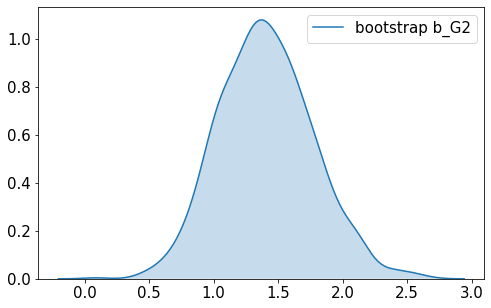

In [460]:
sns.kdeplot(out_df['Group_2'], shade = True, label = 'bootstrap b_G2')

Tất cả những kết quả trên đây cho phép suy luận rằng nhóm Tử vong (G2) có bilirubin tăng cao một cách có ý nghĩa thống kê so với nhóm Sống sót (G1), trung bình 1.407 đơn vị (97.5%CI: 0.751 đến 2.146).

# Suy diễn Bayes phân phối Gamma dùng probflow

## Bước 1: Phác thảo cấu trúc mô hình

In [419]:
import probflow as pf
import tensorflow as tf

from patsy import dmatrices 

import arviz as az

Câu hỏi nghiên cứu so sánh của chúng ta có thể được chuyển thành mô hình như sau:

Ta giả định biến Bilirubin được mô tả bằng một biến số ngẫu nhiên liên tục theo phân phối Gamma gồm 2 tham số:

$$ Bilirubin \sim Gamma(\alpha, \beta)$$

Trong đó $\alpha$ là tham số concentration, $\beta$ là tham số rate, đều là số dương.

Mỗi tham số $\alpha$ , $\beta$ lại được ước tính bởi mô hình tuyến tính đa biến:

$\alpha \sim \mathbf{X}^\top \mathbf{W_a} = x_1 wa_1 + x_2 wa_2 $

$\beta \sim \mathbf{X}^\top \mathbf{W_b} = x_1 wa_1 + x_2 wb_2 $

Với X là design matrix, chứa x1, x2 tương ứng với dummy variable của 2 phân nhóm cần so sánh là G1 và G2

Sau khi giải mô hình này, ta sẽ thu được 2 matrices W_a và W_b chứa giá trị của tham số wa1, wa2 và wb1, wb2 cho phép mô tả 2 phân bố Gamma của bilirubin(G1) và bilirubin(G2):

$$ Bilirubin(G1) \sim Gamma(wa_1, wb_1)$$

$$ Bilirubin(G2) \sim Gamma(wa_2, wb_2)$$

Chú ý: như vậy mô hình này không có intercept

## Bước 2: Chuẩn bị design matrix

Nhi dùng hàm dmatrics của patsy để tạo ra 1 design matrix X gồm 2 dummy variables của biến Class, và không chứa intercept

In [381]:
form = 'BILIRUBIN ~ Class - 1'

Y, X = dmatrices(form,
                 data=df,
                 return_type='dataframe')

X = X.astype('float32')
Y = Y.astype('float32')

Lưu ý: nhớ chuyển data type của X và Y thành float32, nếu không probflow sẽ không hoạt động

## Bước 3: Dựng mô hình GLM bằng probflow

Tiếp theo, ta tạo ra class mô hình GLM, kế thừa cấu trúc và tính năng của class ContinuousModel của probflow.

Mô hình này có 2 nhóm tham số cần xác định:

Ma trận W_a gồm 2 tham số wa1, wa2 tương ứng với 2 tham số alpha của 2 phân bố Gamma của phân nhóm G1, G2

Ma trận W_b gồm 2 tham số wb1, wb2 tương ứng với 2 tham số beta của 2 phân bố Gamma của phân nhóm G1, G2

Hàm likelihood của mô hình cho phép ước lượng biến kết quả Y (bilirubin) theo phân phối Gamma.

Chú ý: wa, wb luôn có giá trị dương, do đó dùng class pf.PositiveParameter, dims = số cột trong design matrix X

In [399]:
class Gamma_reg(pf.ContinuousModel):

    def __init__(self, dims):
        self.wa = pf.PositiveParameter([dims, 1], name = 'W_a')
        self.wb = pf.PositiveParameter([dims, 1], name = 'W_b')
    
    def __call__(self, x):
        return pf.Gamma(concentration = x @ self.wa(),
                        rate = x @ self.wb())

In [400]:
model = Gamma_reg(2)

## Bước 4: Huấn luyện mô hình từ dữ liệu

Mô hình probflow thực chất là 1 probabilistic neural network, được train như các mô hình keras trong tensorflow:

Nhi train mô hình GLM vừa tạo ra trên tập dữ liệu X,Y, với batch_size = 8, learning rate = 0.001 và 3000 epochs

In [598]:
model.fit(X,Y,
          lr = 0.001,
          batch_size=8, 
          epochs=3000)

In [599]:
model.posterior_mean()

{'W_a': array([[3.1196833],
        [1.6165739]], dtype=float32),
 'W_b': array([[2.65854  ],
        [0.6336386]], dtype=float32)}

# Bước 5 : Suy diễn thống kê

Sau khi huấn luyện xong, mô hình đã sẵn sàng cho ta sử dụng, tuy nhiên khác với những mô hình phân bố Gaussian hay Student-t, ta không thể dùng trực tiếp phân bố hậu nghiệm của các tham số W_a, W_b để suy diễn thống kê, mà ta cần đưa các tham số này vào phân bố Gamma rồi lấy mẫu (mô phỏng) rất nhiều (thí dụ 10000 lượt) giá trị của Y(G1) và Y(G2). Phân phối hậu nghiệm của khác biệt giữa 2 phân nhóm sẽ được ước tính bằng hiệu của 2 vectors Y(G2) và Y(G1):  Diff = Y(G2) - Y(G1).

Nhi viết 1 hàm để xuất ra object arviz data:

In [583]:
def posterior_dist(gamma_mod = model,
                   alpha_w = 'W_a',
                   beta_w = 'W_b',
                   grp_names = ['Survived', 'Dead'],
                   n_chain = 5,
                   n_sample = 10000):
    params = model.posterior_mean()
    g1 = pf.Gamma(float(params[alpha_w][0]), 
                  float(params[beta_w][0])).sample(n_sample).numpy()
    g2 = pf.Gamma(float(params[alpha_w][1]), 
                  float(params[beta_w][1])).sample(n_sample).numpy()
    diff = g2 - g1
    sample_dict = {grp_names[0]: g1.reshape(n_chain, n_sample//n_chain), 
                   grp_names[1]: g2.reshape(n_chain, n_sample//n_chain), 
                   'Difference': diff.reshape(n_chain, n_sample//n_chain)}
    
    return az.from_dict(sample_dict)

In [600]:
pw = posterior_dist()

Phân phối hậu nghiệm của Y(G1), Y(G2) như sau:

In [601]:
pw.posterior

<xarray.Dataset>
Dimensions:     (chain: 5, draw: 2000)
Coordinates:
  * chain       (chain) int32 0 1 2 3 4
  * draw        (draw) int32 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    Survived    (chain, draw) float32 0.89715576 1.5405983 ... 1.0070599
    Dead        (chain, draw) float32 1.0148896 3.215996 ... 4.4151826 2.8783422
    Difference  (chain, draw) float32 0.117733836 1.6753978 ... 1.8712822
Attributes:
    created_at:     2020-08-16T19:03:36.930324
    arviz_version:  0.9.0

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Survived'}>],
       [<AxesSubplot:title={'center':'Dead'}>,
        <AxesSubplot:title={'center':'Dead'}>],
       [<AxesSubplot:title={'center':'Difference'}>,
        <AxesSubplot:title={'center':'Difference'}>]], dtype=object)

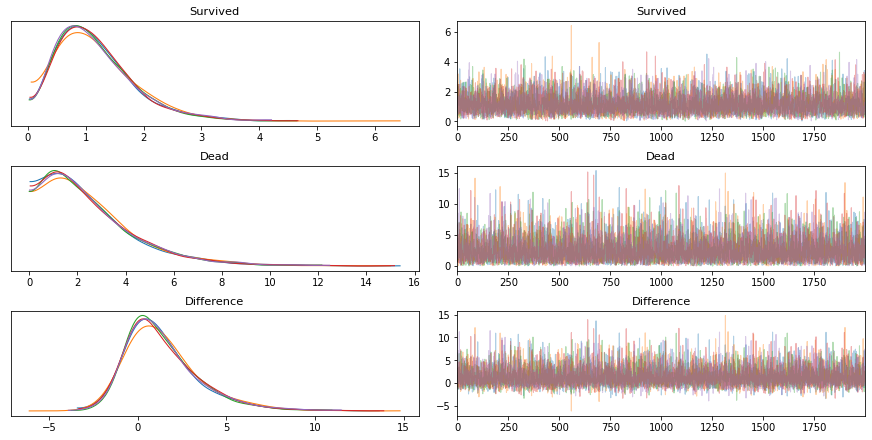

In [602]:
az.plot_trace(pw)

In [603]:
az.summary(pw, 
           hdi_prob = 0.95,
           kind = 'stats',
           stat_funcs={'Median': np.median})

,mean,sd,hdi_2.5%,hdi_97.5%,Median
Survived,1.166,0.663,0.127,2.477,1.045
Dead,2.529,1.976,0.015,6.431,2.040
Difference,1.363,2.081,-1.985,5.804,0.947


array([<AxesSubplot:title={'center':'Survived'}>,
       <AxesSubplot:title={'center':'Dead'}>,
       <AxesSubplot:title={'center':'Difference'}>], dtype=object)

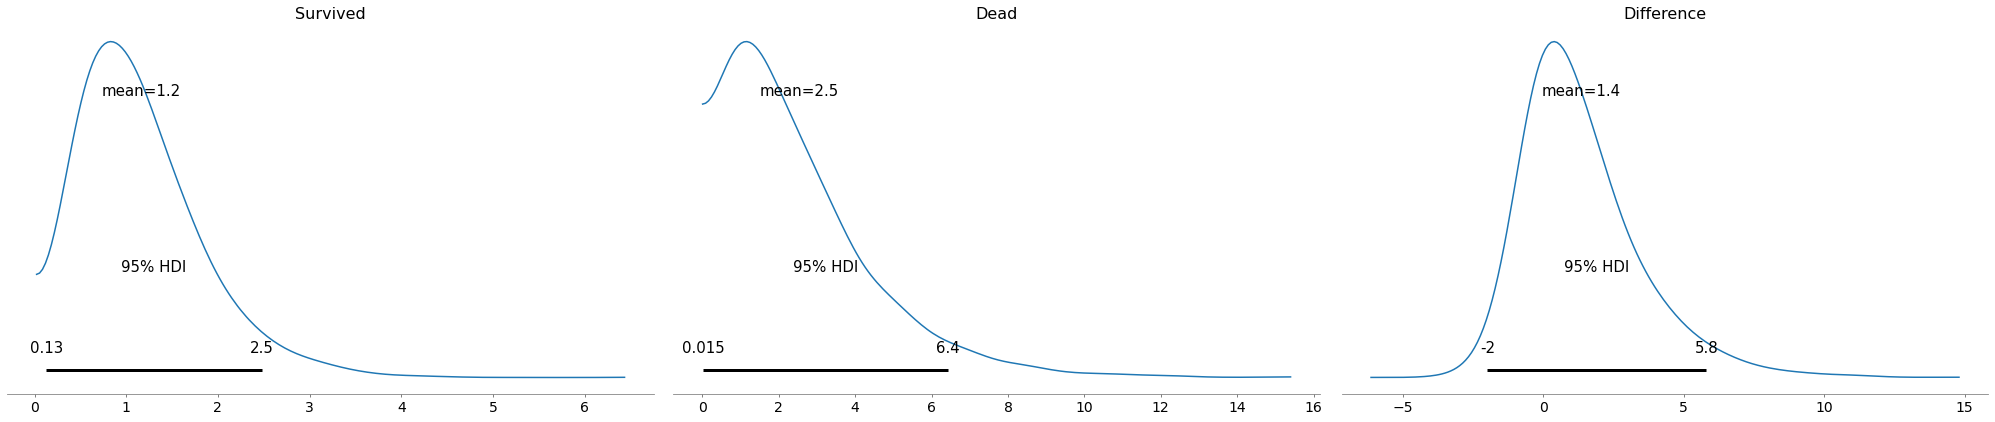

In [604]:
az.plot_posterior(pw, hdi_prob = 0.95,)

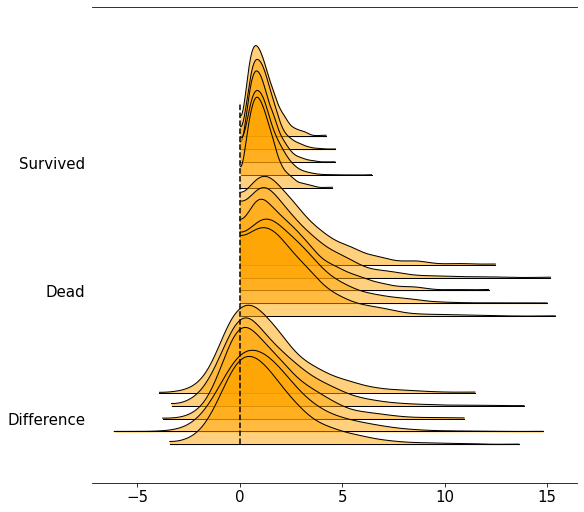

In [606]:
az.plot_forest(pw,
               kind='ridgeplot',
               colors = 'orange',
               ridgeplot_alpha = 0.5,
               linewidth=1,
               combined=False,
               credible_interval = 0.95,
               ridgeplot_overlap=0.8,
               figsize=(8,7))

plt.vlines(x=0, ymin = 0, ymax = 3, color = 'black', linestyles='dashed')

Dựa vào mô hình probflow, ta có thể nói có sự khác biệt trung bình = 1.363 đơn vị giữa 2 phân nhóm G2, G1, với khoảng mật độ cao nhất (HDI) từ -1.98 đến 5.804; kết quả này khá tương đồng với hệ số hồi quy trong mô hình GLM quy ước là 1.397.

Chúc các bạn thực hành vui và hẹn gặp lại...